Importamos las librerías necesarias

In [94]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cornac
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.metrics import Recall, Precision, MAE, RMSE
from cornac.models import ItemKNN, BPR, MF, SVD
from cornac.models import Recommender
from surprise import SVD
from cornac.eval_methods import RatioSplit

Crear un modelo propio

In [95]:
class MeanRecommender(Recommender):
    def __init__(self, name="MeanRecommender"):
        super().__init__(name=name)
        self.item_means = None

    def fit(self, train_set, val_set):
        super().fit(train_set, val_set)
        # Calcular la media de las calificaciones para cada ítem
        self.item_means = np.zeros(train_set.num_items)
        for i in range(train_set.num_items):
            ratings = train_set.matrix[:, i].data
            if len(ratings) > 0:
                self.item_means[i] = np.mean(ratings)
            else:
                self.item_means[i] = 0

    def score(self, user_id, item_id=None):
        if item_id is None:
            return self.item_means
        return self.item_means[item_id]
    
class Hybrid(cornac.models.Recommender):
    def __init__(self, mf_model, knn_model, name="Hybrid"):
        super().__init__(name=name)
        self.mf_model = mf_model
        self.knn_model = knn_model

    def fit(self, train_set, eval_set):
        super().fit(train_set,eval_set)
        self.mf_model.fit(train_set, eval_set)
        self.knn_model.fit(train_set, eval_set)

    def score(self, user_idx, item_idx=None, fraction=(10, 1)):
        mf_scores = self.mf_model.score(user_idx, item_idx)
        knn_scores = self.knn_model.score(user_idx, item_idx)
        total = sum(fraction)
        return (mf_scores*fraction[0] + knn_scores*fraction[1])/total


Cargar el dataset de MovieLens 100K

In [96]:
data = movielens.load_feedback()


url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
# Load the MovieLens 100K dataset
data = movielens.load_feedback()
metadata = movielens.load_plot()

# Convert the data to a pandas DataFrame
df = pd.DataFrame(data, columns=['user_id', 'item_id', 'rating'])

df_meta = pd.DataFrame(metadata)
df_meta = df_meta.transpose()
df_meta.rename(columns={'0': 'Plot'}, inplace=True)


df_meta.columns = ['plot', 'movie_id']

df.head()
#df_meta.head()


,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


### Exploración de Datos ###

In [97]:
n_movies = df['item_id'].nunique()
n_users = df['user_id'].nunique()
n_ratings = df.count().sum()


sparsity = n_ratings/(n_movies*n_users)
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 18.91%


Distribución de Ratings

/tmp/ipykernel_105195/80604846.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=df, palette="viridis")


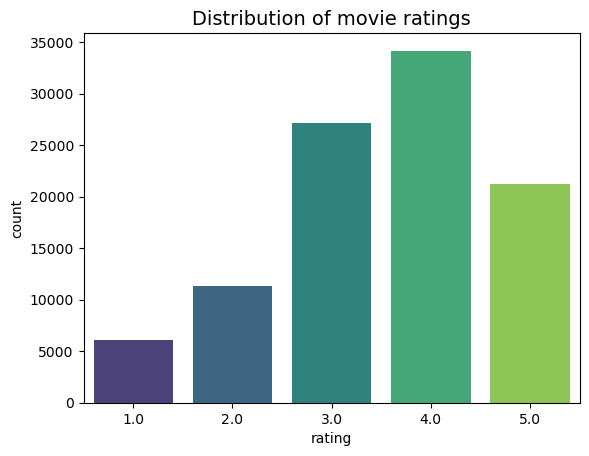

In [98]:
sns.countplot(x="rating", data=df, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [99]:
# Calculate count and mean
df_stats = df
df_stats['count'] = df_stats.groupby('user_id')['rating'].transform('count')
df_stats['mean'] = df_stats.groupby('user_id')['rating'].transform('mean')
df_stats.head()


,user_id,item_id,rating,count,mean
0,196,242,3.0,39,3.615385
1,186,302,3.0,92,3.413043
2,22,377,1.0,128,3.351562
3,244,51,2.0,238,3.651261
4,166,346,1.0,20,3.550000


In [100]:

movie_stats = df_stats.groupby('item_id')['rating'].agg(['count', 'mean'])
movie_stats.head()

c = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {c:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
    bayesian_avg = (c*m+ratings.sum())/(c+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 59.45
Average rating for a given movie: 3.08


In [101]:
df_stats = df_stats.drop(columns='user_id')

bayes_avg = df_stats.groupby('item_id')['rating'].agg(bayesian_avg).reset_index()
bayes_avg.columns = ['item_id', 'bayesian_avg']
df_stats = df_stats.merge(bayes_avg, on='item_id')
df_stats = df_stats.drop_duplicates(subset='item_id')
df_stats = df_stats.sort_values('bayesian_avg', ascending=False)
df_stats.head()

,item_id,rating,count,mean,bayesian_avg
499,50,5.0,150,3.353333,4.240
243,318,5.0,216,4.032407,4.235
313,64,5.0,140,4.328571,4.208
210,483,5.0,93,3.903226,4.185
400,12,5.0,51,4.333333,4.147


Definir el método de evaluación

In [102]:
ratio_split = RatioSplit(data=data, test_size=0.2, rating_threshold=4.0, exclude_unknowns=True, verbose=True)


rating_threshold = 4.0
exclude_unknowns = True
---
Training data:
Number of users = 943
Number of items = 1647
Number of ratings = 80000
Max rating = 5.0
Min rating = 1.0
Global mean = 3.5
---
Test data:
Number of users = 943
Number of items = 1647
Number of ratings = 19959
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 943
Total items = 1647


Definir los modelos a emplear

In [103]:
mean_recommender = MeanRecommender() # Modelo propio
mf = MF(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
svd = cornac.models.SVD()
knn = ItemKNN(k=20, similarity='cosine', name='ItemKNN')
bpr = cornac.models.BPR(k=10, max_iter=25, learning_rate=0.01, lambda_reg=0.02)
hybrid = Hybrid(mf_model=mf, knn_model=knn)



Definir las metricas a utilizar

In [104]:
metrics = []
metrics.append(MAE())
metrics.append(RMSE())
metrics.append(Recall(10))
metrics.append(Precision(10))

Definir el experimento con el modelo propio


In [105]:
experiment = cornac.Experiment(eval_method=ratio_split, models=[mean_recommender, mf, bpr, svd, knn, hybrid], metrics=metrics)

Ejecutar el experimento

In [106]:
experiment.run()
# experiment2.run()


[MeanRecommender] Training started!

[MeanRecommender] Evaluation started!


Rating:   0%|          | 0/19959 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[MF] Training started!

[MF] Evaluation started!


Rating:   0%|          | 0/19959 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[BPR] Training started!

[BPR] Evaluation started!


Rating:   0%|          | 0/19959 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[SVD] Training started!

[SVD] Evaluation started!


Rating:   0%|          | 0/19959 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[ItemKNN] Training started!


  0%|          | 0/1647 [00:00<?, ?it/s]


[ItemKNN] Evaluation started!


Rating:   0%|          | 0/19959 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


[Hybrid] Training started!


  0%|          | 0/1647 [00:00<?, ?it/s]


[Hybrid] Evaluation started!


Rating:   0%|          | 0/19959 [00:00<?, ?it/s]

Ranking:   0%|          | 0/942 [00:00<?, ?it/s]


TEST:
...
                |    MAE |   RMSE | Precision@10 | Recall@10 | Train (s) | Test (s)
--------------- + ------ + ------ + ------------ + --------- + --------- + --------
MeanRecommender | 0.8417 | 1.0040 |       0.0000 |    0.0000 |    0.4575 |   1.0405
MF              | 0.7534 | 0.9161 |       0.0761 |    0.0535 |    0.0495 |   1.6719
BPR             | 2.1598 | 2.3618 |       0.1125 |    0.1135 |    0.2084 |   1.3060
SVD             | 0.7632 | 0.9259 |       0.0600 |    0.0409 |    0.0355 |   1.1671
ItemKNN         | 0.8271 | 1.0039 |       0.0279 |    0.0169 |    0.1928 |   7.1827
Hybrid          | 0.7617 | 0.9330 |       0.0687 |    0.0498 |    0.1934 |   7.3811



Extraer los resultados de las métricas

In [107]:
results = experiment.result
mean_mae = results[0].metric_avg_results['MAE']
mean_rmse = results[0].metric_avg_results['RMSE']
mean_precision = results[0].metric_avg_results['Precision@10']
mf_mae = results[1].metric_avg_results['MAE']
mf_rmse = results[1].metric_avg_results['RMSE']
mf_precision = results[1].metric_avg_results['Precision@10']
bpr_mae = results[2].metric_avg_results['MAE']
bpr_rmse = results[2].metric_avg_results['RMSE']
bpr_precision = results[2].metric_avg_results['Precision@10']
svd_mae = results[3].metric_avg_results['MAE']
svd_rmse = results[3].metric_avg_results['RMSE']
svd_precision = results[3].metric_avg_results['Precision@10']
knn_mae = results[4].metric_avg_results['MAE']
knn_rmse = results[4].metric_avg_results['RMSE']
knn_precision = results[4].metric_avg_results['Precision@10']

Crear un gráfico de barras para mostrar los resultados

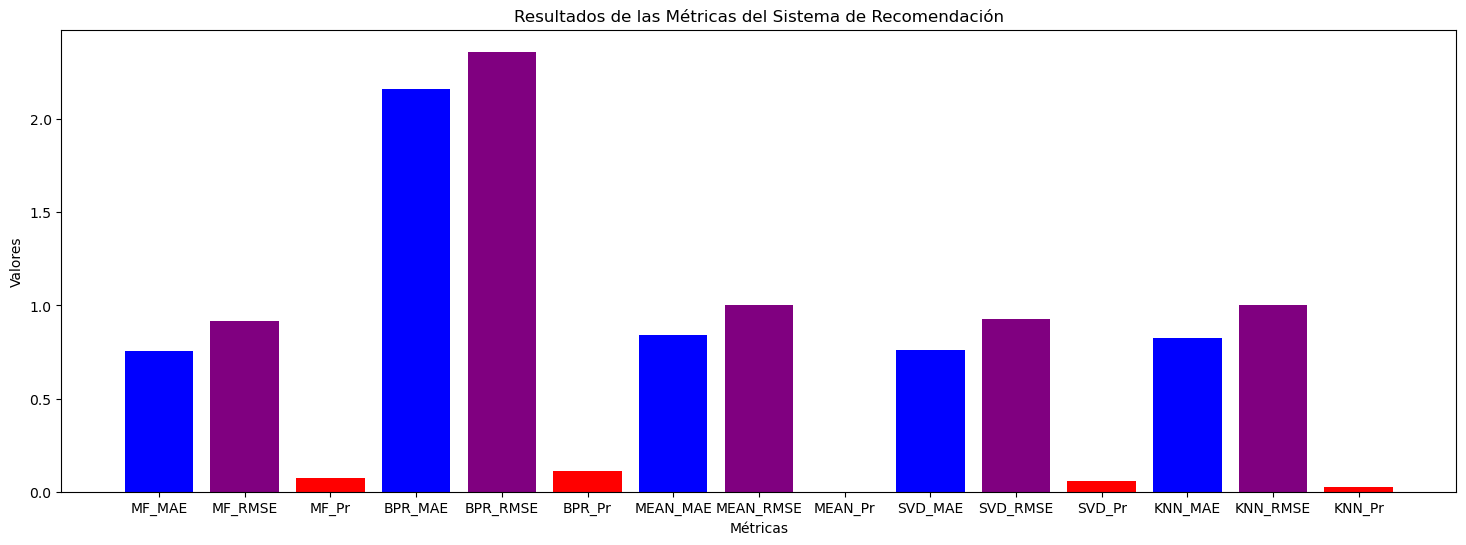

In [108]:
metrics_names = ['MF_MAE', 'MF_RMSE', 'MF_Pr', 'BPR_MAE', 'BPR_RMSE', 'BPR_Pr', 'MEAN_MAE', 'MEAN_RMSE', 'MEAN_Pr', 'SVD_MAE', 'SVD_RMSE', 'SVD_Pr', 'KNN_MAE', 'KNN_RMSE', 'KNN_Pr']
values = [mf_mae, mf_rmse, mf_precision, bpr_mae, bpr_rmse, bpr_precision, mean_mae, mean_rmse, mean_precision, svd_mae, svd_rmse, svd_precision, knn_mae, knn_rmse, knn_precision] 

plt.figure(figsize=(18, 6))
plt.bar(metrics_names, values, color=['blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red', 'blue', 'purple', 'red'])
plt.xlabel('Métricas')
plt.ylabel('Valores')
plt.title('Resultados de las Métricas del Sistema de Recomendación')
plt.show()
